## This notebook studies the stochasitcity of the crossbar model

In [1]:
import sys
sys.path.append("..")

In [2]:
import matplotlib.pyplot as plt
from memristor.devices import StaticMemristor, DynamicMemristor, DynamicMemristorFreeRange, DynamicMemristorStuck
from memristor.crossbar.model import LineResistanceCrossbar
import torch
from tqdm import tqdm
import numpy as np

#### First, find appropriate programming voltage for each bitline and wordline to ensure v_p is within range

range [−0.8 V to −1.5 V]/[0.8 V to 1.15 V]

In [3]:
torch.set_default_dtype(torch.float64) # set default torch value type

In [50]:
def plot_voltage_drop(crossbar, v_wl_applied, v_bl_applied, imshow=True, txt=""):
    ideal_range = []
    crossbar.lineres_memristive_vmm(v_wl_applied, v_bl_applied, iter=1)
    M = torch.t(crossbar.cache["V_wl"]-crossbar.cache["V_bl"])
    # show % within range
    bt1 = torch.numel(M[(-1.5<=M) & (M<=-0.8)])/torch.numel(M)
    bt2 = torch.numel(M[(0.8<=M) & (M<=1.15)])/torch.numel(M)
    if imshow:
        im = plt.imshow(M,
                        interpolation='none', aspect='equal', cmap = 'cividis')
        ax = plt.gca()
        # no need for axis
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title("Cell voltage TiOx crossbar")
        ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
        plt.colorbar()
        #if bt1 > bt2:
        #    plt.clim(-1.5, -0.8)
        #else:
        #    plt.clim(0.7, 1.3)
        fig = plt.gcf()
        #fig.savefig(f'crossbar_conductance_cycle_log/voltage_drop_{txt}.png', dpi=100)
        plt.show()
        fig.savefig("voltage drop wordline")
        
        hist, bins = np.histogram(M, bins=15)
        plt.plot(bins[:-1], hist)
        plt.title("voltage drop histogram")
        plt.xlabel("Voltage (V)")
        fig = plt.gcf()
        fig.savefig(f'voltage_drop_histogram.png', dpi=100)
        plt.show()
    if imshow:
        print(f"percent memristor cell voltage in range [−0.8 V to −1.5 V]/[0.8 V to 1.15 V]: {100*max(bt1, bt2)}%:")
    return 100*max(bt1, bt2)

In [38]:
crossbar_params = {'r_wl': 20, 'r_bl': 20, 'r_in':10, 'r_out':10, 'V_SOURCE_MODE':'|_|'}
memristor_model = DynamicMemristorStuck
memristor_params = {'frequency': 1e8, 'temperature': 60+273}
ideal_w = 65*torch.ones(16, 8)*1e-6

In [39]:
crossbar = LineResistanceCrossbar(memristor_model, memristor_params, ideal_w, crossbar_params)

In [40]:
best_v_wl_applied = 1.2 * torch.ones(8)#torch.concat([1.2*torch.ones(12,), torch.linspace(1.2, 1, 4)], dim=0)#torch.concat([3.1*torch.ones(12,), torch.linspace(3.1, 2.4,4)], dim=0)
best_v_bl_applied = 1.5 * torch.concat([torch.linspace(1, 1.2,16), 1.2*torch.ones(16,),torch.linspace(1.2, 1,16)], dim=0)

##### Reset operation cell voltage drop

##### Set operation cell voltage drop

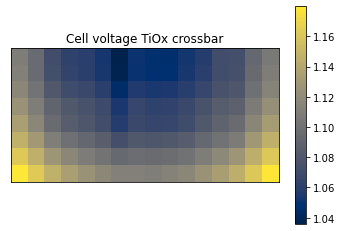

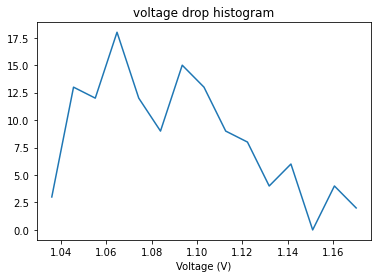

percent memristor cell voltage in range [−0.8 V to −1.5 V]/[0.8 V to 1.15 V]: 95.3125%:


95.3125

In [51]:
plot_voltage_drop(crossbar, best_v_wl_applied, 0*torch.ones(16,))

#### Now we can apply programming voltage

In [92]:
# useful functions
def program_crossbar(crossbar, v_wl_applied, v_bl_applied, t_p, iterations, imshow=True):
    ideal_w_hist=[]
    fitted_w_hist=[]
    for i in range(iterations):
        #  program the crossbar
        ideal_w_hist.append(torch.clone(crossbar.ideal_w).view(-1))
        fitted_w_hist.append(torch.clone(crossbar.fitted_w).view(-1))
        crossbar.lineres_memristive_programming(v_wl_applied, v_bl_applied, t_p)
    # conductance change history
    ideal_w_hist = torch.stack(ideal_w_hist, dim=1)
    fitted_w_hist = torch.stack(fitted_w_hist, dim=1)
    if imshow:    
        for i in range(ideal_w_hist.shape[0]):
            plt.plot(range(iterations), ideal_w_hist[i, :]*1e6)
        plt.title("ideal conductance change")
        plt.ylabel("conductance (uS)")
        plt.ylim([1, 400])
        plt.yscale('log')
        plt.show()
        
        for i in range(fitted_w_hist.shape[0]):
            plt.plot(range(iterations), fitted_w_hist[i, :]*1e6)
        plt.title("fitted conductance change")
        plt.ylabel("conductance (uS)")
        plt.ylim([1, 400])
        plt.yscale('log')
        plt.show()
    #print(ideal_w_hist.shape, fitted_w_hist.shape)
    return ideal_w_hist, fitted_w_hist
        
def crossbar_statistics(crossbar, txt=""):
    print(txt)
    #ideal conductance
    plt.matshow(torch.t(crossbar.ideal_w)*1e6)
    plt.title("ideal conductance")
    plt.clim(10, 150)
    plt.colorbar()
    fig = plt.gcf()
    fig.savefig(f'crossbar_conductance_cycle_log/ideal_conductance_{txt}.png', dpi=100)
    plt.show()
    # best fit conductance
    plt.matshow(torch.t(crossbar.fitted_w)*1e6)
    plt.title("fitted conductance")
    plt.clim(0, 150)
    plt.colorbar()
    fig = plt.gcf()
    fig.savefig(f'crossbar_conductance_cycle_log/fitted_conductance_{txt}.png', dpi=100)
    plt.show()

    # Histograms
    hist, bins = np.histogram(crossbar.ideal_w, bins=100)
    plt.plot(bins[:-1]*1e6, hist)
    plt.title("ideal conductance histogram")
    plt.xlabel("conductance (uS)")
    plt.xlim([0,150])
    plt.ylim([0,100])
    fig = plt.gcf()
    fig.savefig(f'crossbar_conductance_cycle_log/ideal_histogram_{txt}.png', dpi=100)
    plt.show()

    hist, bins = np.histogram(crossbar.fitted_w, bins=100)
    plt.plot(bins[:-1]*1e6, hist)
    plt.title("fitted conductance histogram")
    plt.xlabel("conductance (uS)")
    plt.xlim([0,150])
    plt.ylim([0,100])
    fig = plt.gcf()
    fig.savefig(f'crossbar_conductance_cycle_log/fitted_histogram_{txt}.png', dpi=100)
    plt.show()
    
    #stuck memristors
    stuck_mask = [[0 if crossbar.memristors[i][j].stuck else 1 for j in range(ideal_w.shape[1])] for i in range(ideal_w.shape[0])]
    stuck_mask = torch.t(torch.tensor(stuck_mask))
    plt.title("stuck memristors")
    plt.matshow(stuck_mask)
    plt.colorbar()
    fig = plt.gcf()
    fig.savefig(f'crossbar_conductance_cycle_log/stuck_devices_{txt}.png', dpi=100)
    plt.show()
    print("% stuck:", f"{100-torch.sum(stuck_mask)/torch.numel(stuck_mask) * 100}%")
    print("reset in range:", plot_voltage_drop(crossbar, 0*torch.ones(16,), best_v_bl_applied, imshow=True, txt=txt+"_reset_"))
    print("set in range:", plot_voltage_drop(crossbar, best_v_wl_applied, 0*torch.ones(48,), imshow=True, txt=txt+"_set_"))
    
    return torch.clone(crossbar.fitted_w)

##### Multi-cycle programming

In [93]:
# before programming

In [94]:
t_p_set = 0.25e-3
t_p_reset = 0.5e-3
n_set = 15
n_reset = 40
cycles = 6

/Users/jvjv/Github/pytorch-metal-oxide-memristor-crossbar/Notebooks/../memristor/crossbar/model.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ideal_w[i,j] = torch.tensor(self.memristors[i][j].g_0)


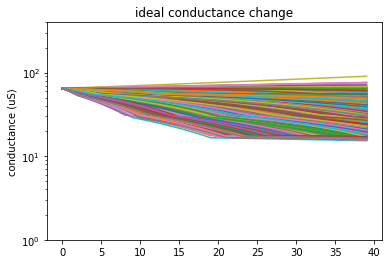

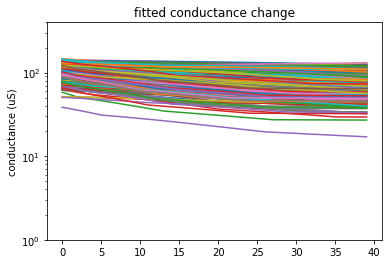

/Users/jvjv/Github/pytorch-metal-oxide-memristor-crossbar/Notebooks/../memristor/crossbar/model.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ideal_w[i,j] = torch.tensor(self.memristors[i][j].g_0)


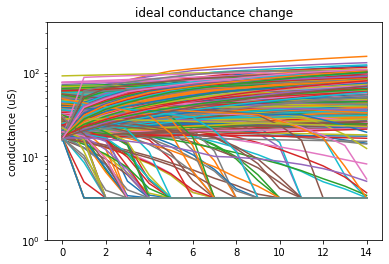

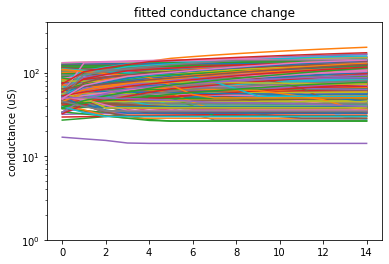

subcycle_0


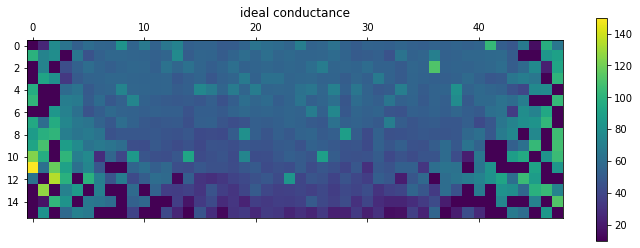

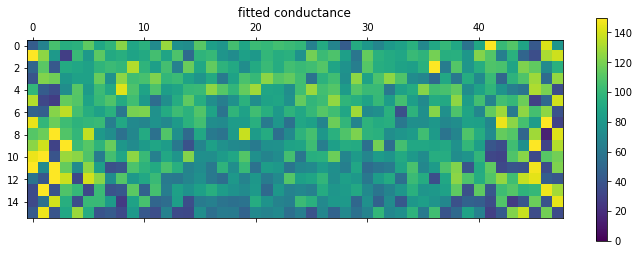

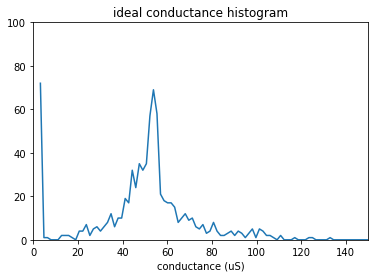

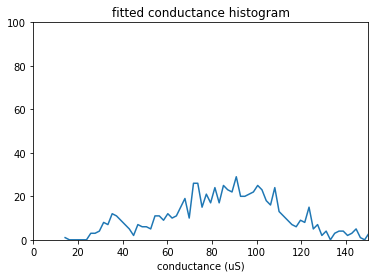

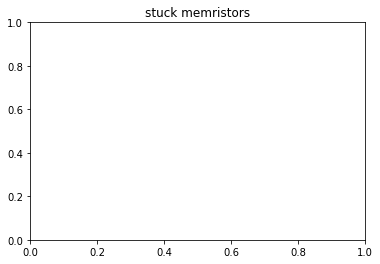

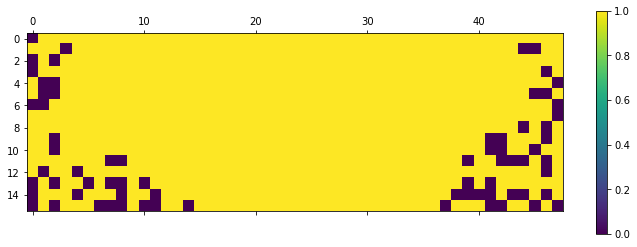

% stuck: 9.244791666666657%


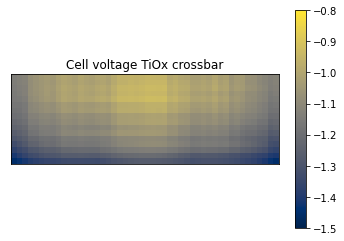

percent memristor cell voltage in range [−0.8 V to −1.5 V]/[0.8 V to 1.15 V]: 100.0%:
reset in range: 100.0


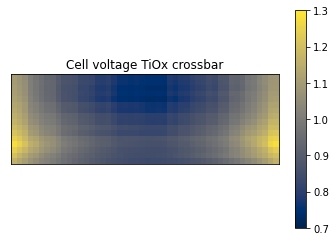

percent memristor cell voltage in range [−0.8 V to −1.5 V]/[0.8 V to 1.15 V]: 79.6875%:
set in range: 79.6875


/Users/jvjv/Github/pytorch-metal-oxide-memristor-crossbar/Notebooks/../memristor/crossbar/model.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ideal_w[i,j] = torch.tensor(self.memristors[i][j].g_0)


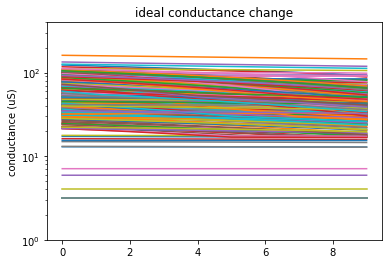

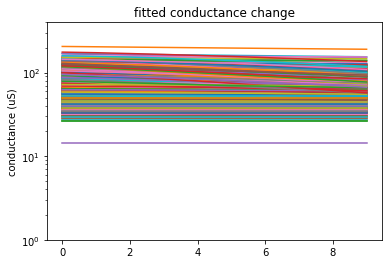

subcycle_1


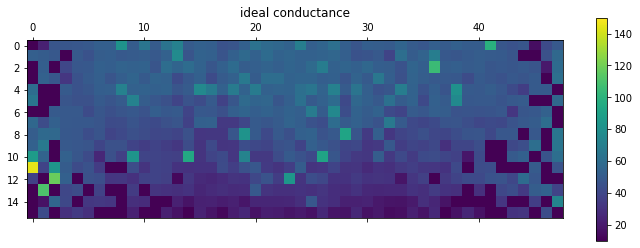

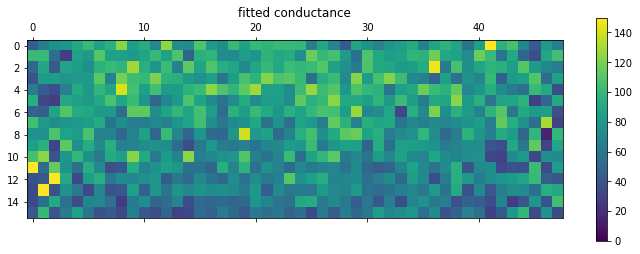

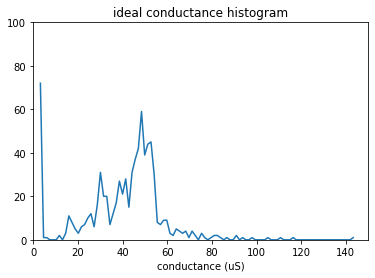

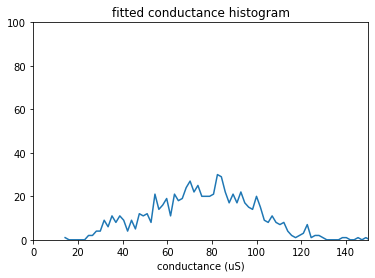

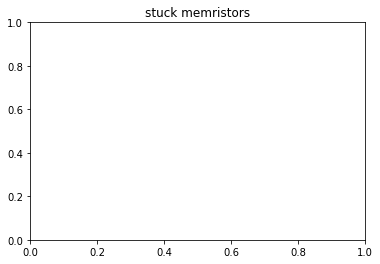

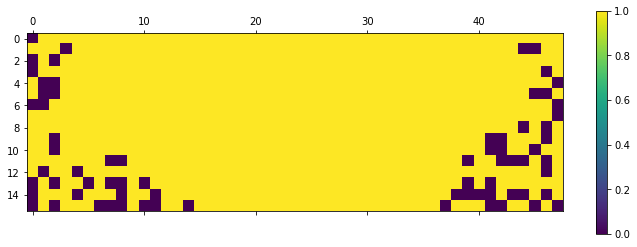

% stuck: 9.244791666666657%


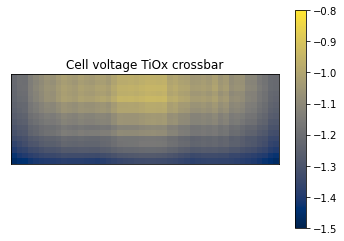

percent memristor cell voltage in range [−0.8 V to −1.5 V]/[0.8 V to 1.15 V]: 100.0%:
reset in range: 100.0


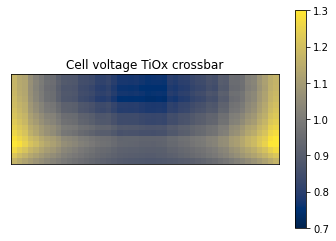

percent memristor cell voltage in range [−0.8 V to −1.5 V]/[0.8 V to 1.15 V]: 76.82291666666666%:
set in range: 76.82291666666666


/Users/jvjv/Github/pytorch-metal-oxide-memristor-crossbar/Notebooks/../memristor/crossbar/model.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ideal_w[i,j] = torch.tensor(self.memristors[i][j].g_0)


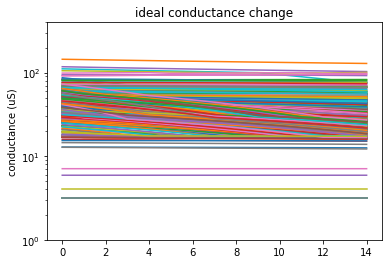

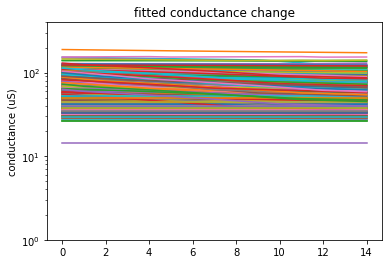

subcycle_2


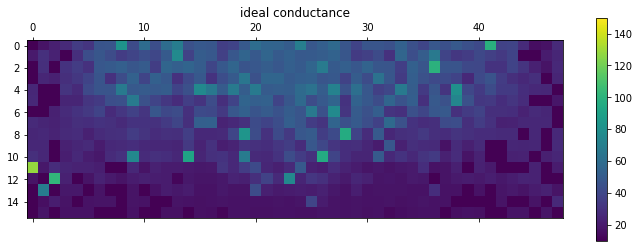

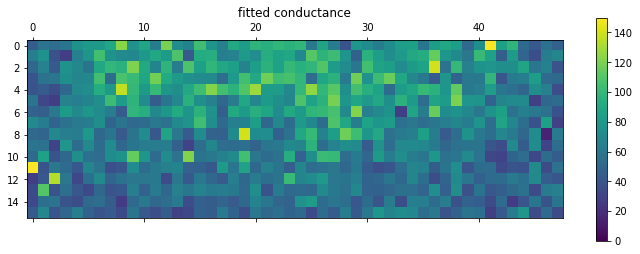

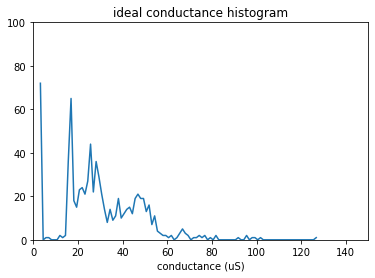

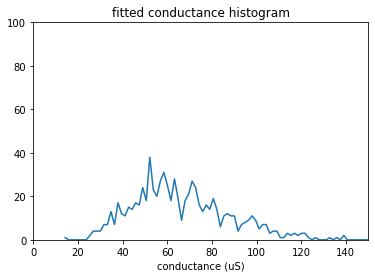

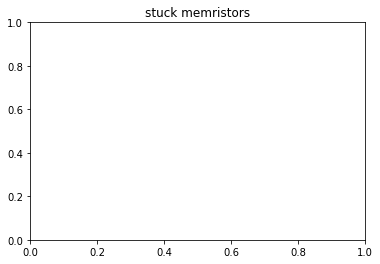

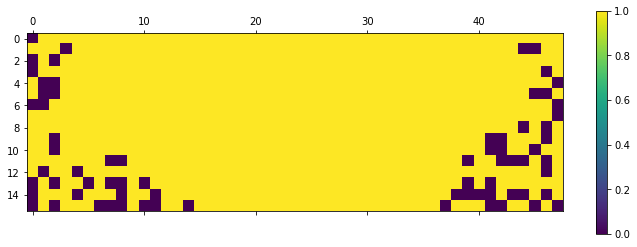

% stuck: 9.244791666666657%


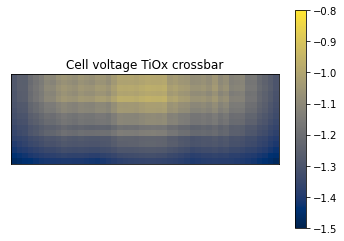

percent memristor cell voltage in range [−0.8 V to −1.5 V]/[0.8 V to 1.15 V]: 100.0%:
reset in range: 100.0


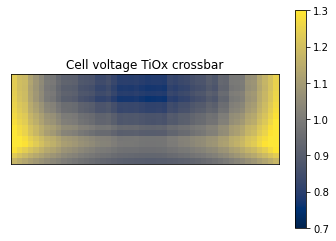

percent memristor cell voltage in range [−0.8 V to −1.5 V]/[0.8 V to 1.15 V]: 76.30208333333334%:
set in range: 76.30208333333334


/Users/jvjv/Github/pytorch-metal-oxide-memristor-crossbar/Notebooks/../memristor/crossbar/model.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ideal_w[i,j] = torch.tensor(self.memristors[i][j].g_0)


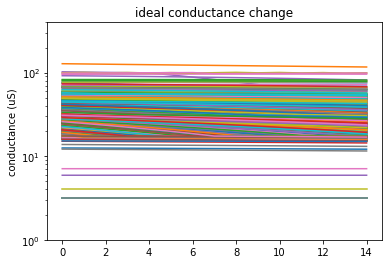

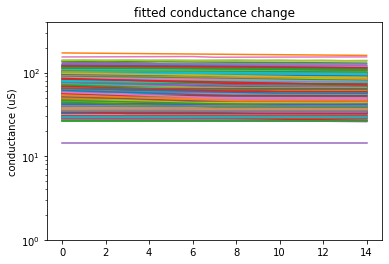

subcycle_3


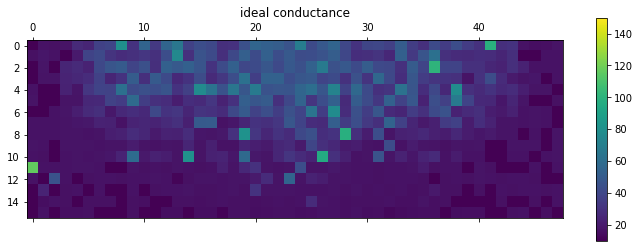

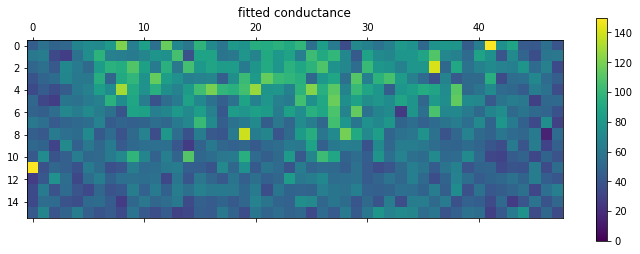

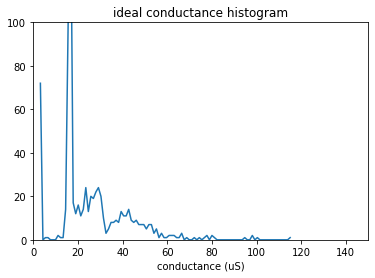

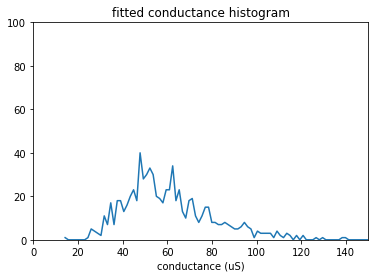

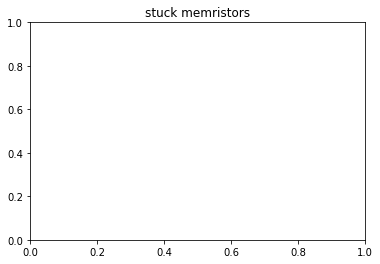

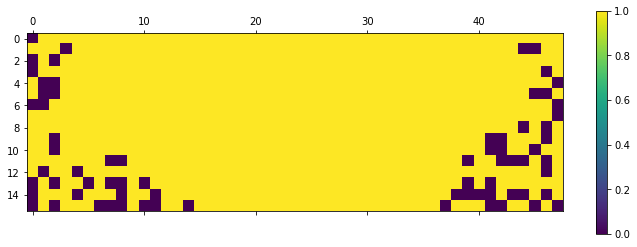

% stuck: 9.244791666666657%


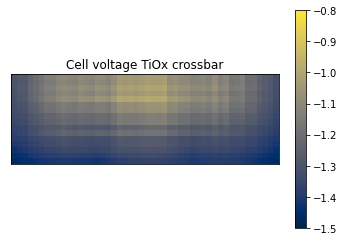

percent memristor cell voltage in range [−0.8 V to −1.5 V]/[0.8 V to 1.15 V]: 100.0%:
reset in range: 100.0


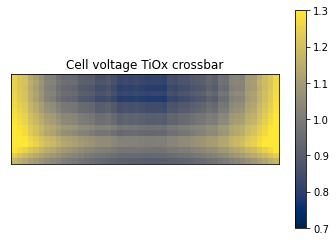

percent memristor cell voltage in range [−0.8 V to −1.5 V]/[0.8 V to 1.15 V]: 77.60416666666666%:
set in range: 77.60416666666666


/Users/jvjv/Github/pytorch-metal-oxide-memristor-crossbar/Notebooks/../memristor/crossbar/model.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ideal_w[i,j] = torch.tensor(self.memristors[i][j].g_0)


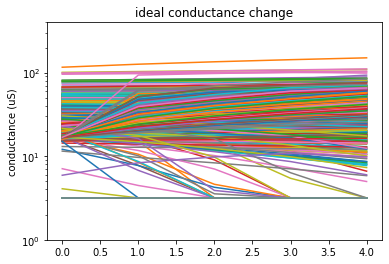

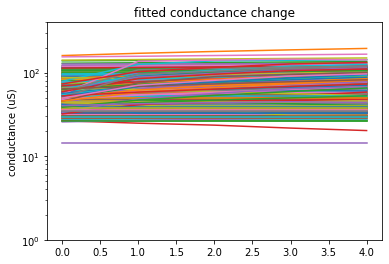

subcycle_4


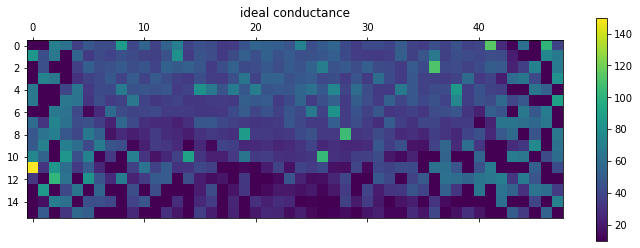

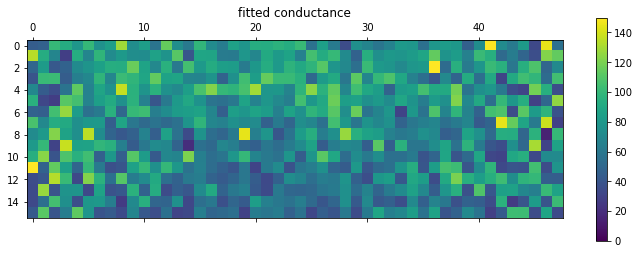

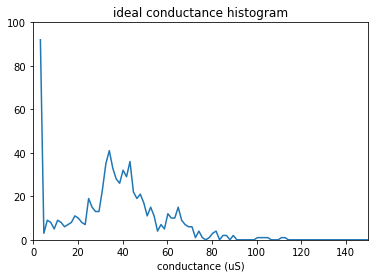

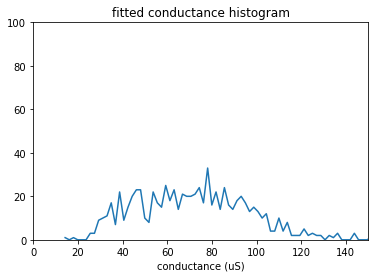

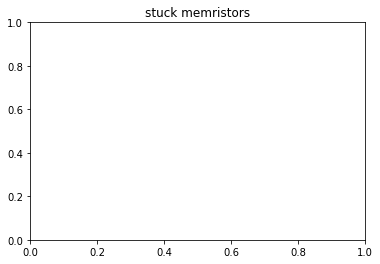

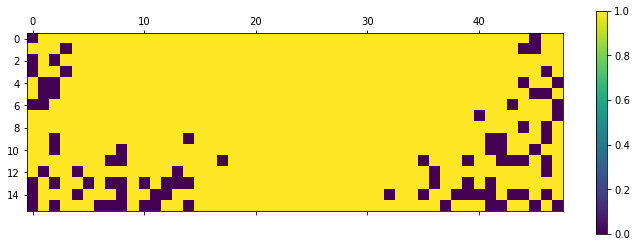

% stuck: 11.588541666666657%


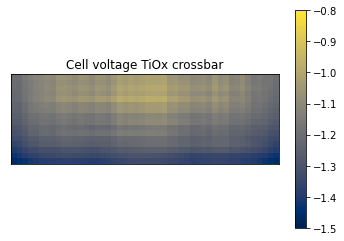

percent memristor cell voltage in range [−0.8 V to −1.5 V]/[0.8 V to 1.15 V]: 100.0%:
reset in range: 100.0


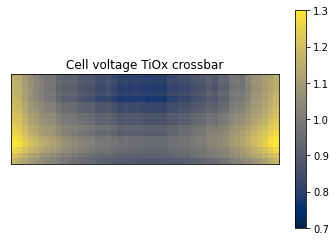

percent memristor cell voltage in range [−0.8 V to −1.5 V]/[0.8 V to 1.15 V]: 85.546875%:
set in range: 85.546875


/Users/jvjv/Github/pytorch-metal-oxide-memristor-crossbar/Notebooks/../memristor/crossbar/model.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ideal_w[i,j] = torch.tensor(self.memristors[i][j].g_0)


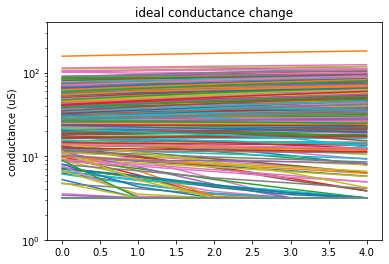

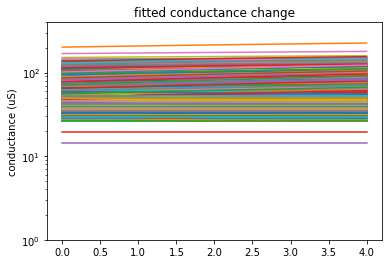

subcycle_5


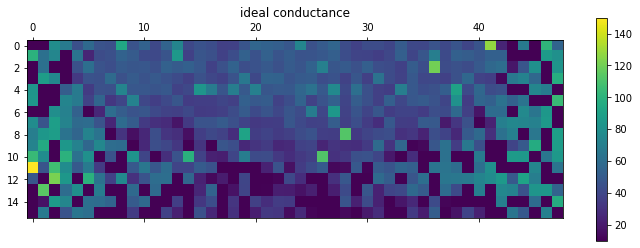

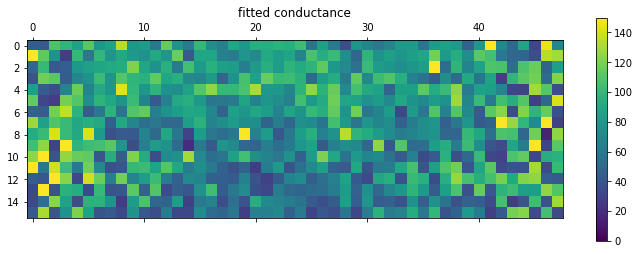

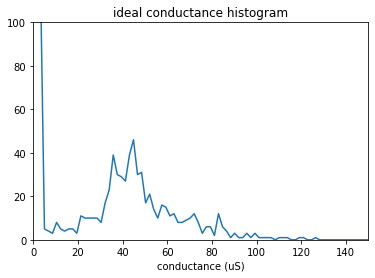

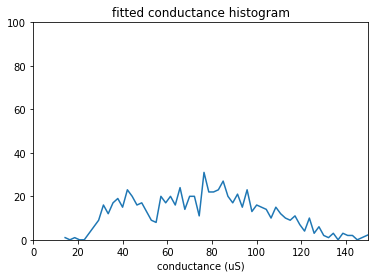

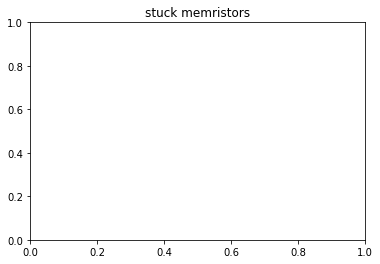

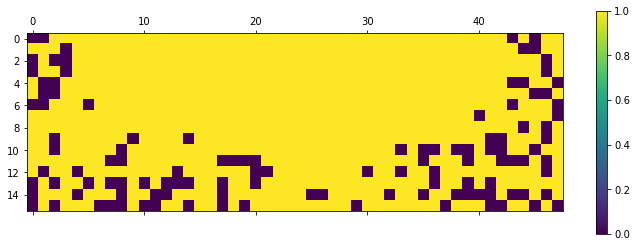

% stuck: 15.104166666666657%


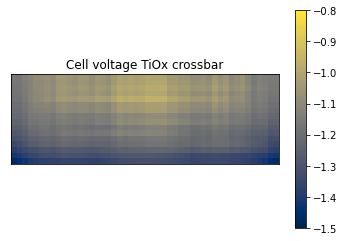

percent memristor cell voltage in range [−0.8 V to −1.5 V]/[0.8 V to 1.15 V]: 100.0%:
reset in range: 100.0


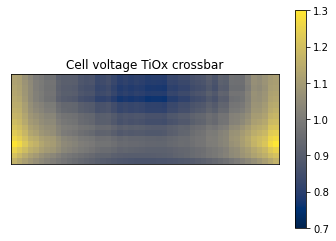

percent memristor cell voltage in range [−0.8 V to −1.5 V]/[0.8 V to 1.15 V]: 87.5%:
set in range: 87.5


In [95]:
ideal_conductance_hist = torch.zeros([crossbar.m*crossbar.n, cycles*(n_set+n_reset)])
fitted_conductance_hist = torch.zeros([crossbar.m*crossbar.n, cycles*(n_set+n_reset)])
#weight_checkpoint = {"ideal":torch.zeros([]), "fitted":torch.zeros([])}

i=0
program_crossbar(crossbar, torch.zeros(16,), best_v_bl_applied, t_p_reset, n_reset, imshow=True)
program_crossbar(crossbar, best_v_wl_applied, torch.zeros(48,), t_p_set, n_set, imshow=True)

hist_list = []
# first reset
hist_list.append(crossbar_statistics(crossbar, txt=f"subcycle_0"))
program_crossbar(crossbar, torch.zeros(16,), best_v_bl_applied, t_p_reset, 10, imshow=True)
hist_list.append(crossbar_statistics(crossbar, txt=f"subcycle_1"))
program_crossbar(crossbar, torch.zeros(16,), best_v_bl_applied, t_p_reset, 15, imshow=True)
hist_list.append(crossbar_statistics(crossbar, txt=f"subcycle_2"))
program_crossbar(crossbar, torch.zeros(16,), best_v_bl_applied, t_p_reset, 15, imshow=True)
hist_list.append(crossbar_statistics(crossbar, txt=f"subcycle_3"))
# then set
program_crossbar(crossbar, best_v_wl_applied, torch.zeros(48,), t_p_set, 5, imshow=True)
hist_list.append(crossbar_statistics(crossbar, txt=f"subcycle_4"))
program_crossbar(crossbar, best_v_wl_applied, torch.zeros(48,), t_p_set, 5, imshow=True)
hist_list.append(crossbar_statistics(crossbar, txt=f"subcycle_5"))

In [96]:
for i in range(len(hist_list)):
    print(torch.std_mean(hist_list[i]*1e6))

(tensor(27.6340), tensor(86.8209))
(tensor(23.1725), tensor(76.8359))
(tensor(21.8171), tensor(67.0569))
(tensor(20.2752), tensor(61.7567))
(tensor(25.1506), tensor(72.5803))
(tensor(29.1283), tensor(77.3247))


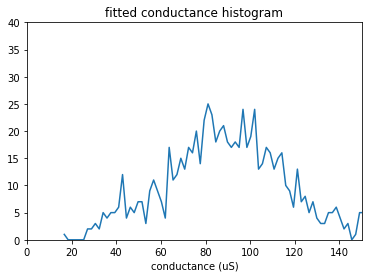

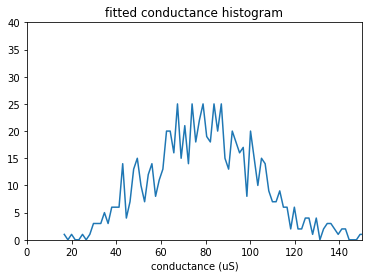

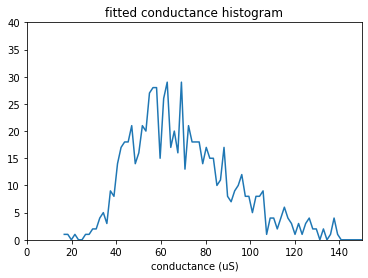

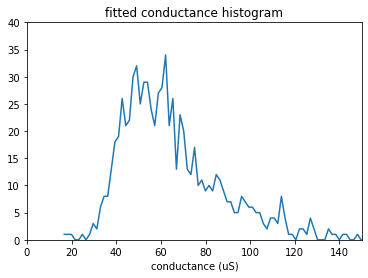

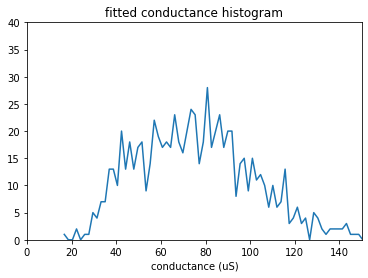

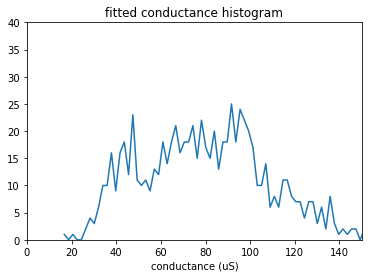

In [82]:
for i in range(6):
    hist, bins = np.histogram(hist_list[i], bins=100)
    plt.plot(bins[:-1]*1e6, hist)
    plt.title("fitted conductance histogram")
    plt.xlabel("conductance (uS)")
    plt.xlim([0,150])
    plt.ylim([0,40])
    fig = plt.gcf()
    fig.savefig(f'crossbar_conductance_cycle_log/fitted_histogram_subcycle_{i}.png', dpi=100)
    plt.show()
